In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [4]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [5]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [6]:
vgg11_layers = get_vgg_layers(vgg16_config, batch_norm = True)

In [7]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [8]:
OUTPUT_DIM = 10

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [9]:
import torchvision.models as models

pretrained_model = models.vgg16_bn(pretrained = False)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [11]:
IN_FEATURES = pretrained_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [12]:
pretrained_model.classifier[-1] = final_fc

In [13]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [14]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 134,309,962 trainable parameters


In [16]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [17]:
ROOT = '.data'

train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)


Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


validation split





In [18]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [19]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [20]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [21]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

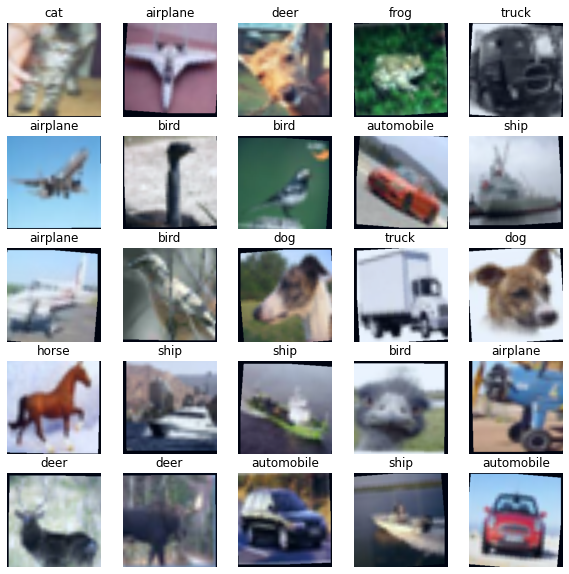

In [22]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [23]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

### Training the Model



In [24]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [25]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [26]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [27]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

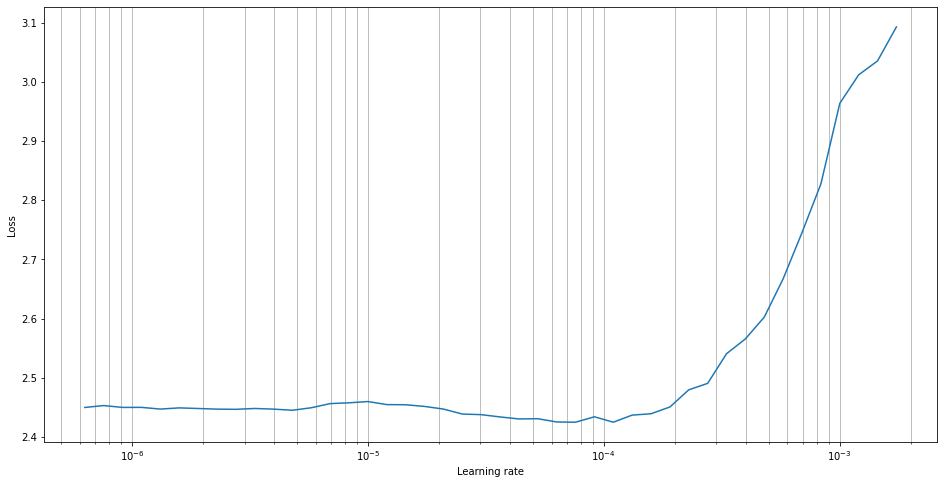

In [28]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

In [29]:
FOUND_LR = 10e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [30]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 10s
	Train Loss: 2.669 | Train Acc: 12.56%
	 Val. Loss: 2.060 |  Val. Acc: 17.37%
Epoch: 02 | Epoch Time: 8m 10s
	Train Loss: 2.115 | Train Acc: 15.44%
	 Val. Loss: 1.946 |  Val. Acc: 20.57%
Epoch: 03 | Epoch Time: 8m 11s
	Train Loss: 2.004 | Train Acc: 17.84%
	 Val. Loss: 1.840 |  Val. Acc: 24.41%
Epoch: 04 | Epoch Time: 8m 11s
	Train Loss: 1.882 | Train Acc: 23.33%
	 Val. Loss: 1.786 |  Val. Acc: 28.24%
Epoch: 05 | Epoch Time: 8m 11s
	Train Loss: 1.800 | Train Acc: 26.51%
	 Val. Loss: 1.703 |  Val. Acc: 31.45%
Epoch: 06 | Epoch Time: 8m 11s
	Train Loss: 1.720 | Train Acc: 29.87%
	 Val. Loss: 1.618 |  Val. Acc: 36.23%
Epoch: 07 | Epoch Time: 8m 11s
	Train Loss: 1.633 | Train Acc: 33.83%
	 Val. Loss: 1.527 |  Val. Acc: 39.56%
Epoch: 08 | Epoch Time: 8m 11s
	Train Loss: 1.496 | Train Acc: 40.15%
	 Val. Loss: 1.366 |  Val. Acc: 48.32%
Epoch: 09 | Epoch Time: 8m 11s
	Train Loss: 1.352 | Train Acc: 48.41%
	 Val. Loss: 1.157 |  Val. Acc: 57.02%
Epoch: 10 | Epoch T

In [35]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.441 | Test Acc: 85.24%


### Examining the Model


In [36]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_iterator)

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

PCA representations.

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

t-SNE representations.

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data